[View in Colaboratory](https://colab.research.google.com/github/Jamaneth/music-genre-finder/blob/master/%E2%80%9Cmusic_genre_CNNmodel_256.ipynb)

# Modelling music genres with Convolutional Neural Networks

The previous notebook was mostly about **data processing**:
- Download the initial data,
- Reduce it,
- Make it more readable.

Here, we will be using the output of that previous notebook.

## Importing the data we need

### Downloading the main packages

Note: the Google Drive download **should work** no matter the Google account the user may choose for the authentication.

In [1]:
!pip install psutil
!pip install librosa
!pip install -U -q PyDrive

In [0]:
# to install pytorch on colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import psutil
import pickle

import librosa
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

%matplotlib inline

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

### Data import

In [6]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

dtype = torch.FloatTensor
if use_gpu:
    dtype = torch.cuda.FloatTensor

Using gpu: True 


In [0]:
# If equal to True: we download the full dataset on Google Drive
# Else: we download the .zip file with the 1000 songs only
full_data_download = False

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

small_id = "1maJ4o_aHSy-ZLHUzOYuQ0QnRbS3rIciX"
downloaded = gdrive.CreateFile({'id': small_id})
downloaded.GetContentFile('small_tracks.csv')
tracks = pd.read_csv('small_tracks.csv')

tracks_id = "1me5bv76Fd9mFyJd25TSzOrl6SrcxsFFk"
downloaded = gdrive.CreateFile({'id': tracks_id})
downloaded.GetContentFile('tracks.csv')

model_1_id = "1nKNXKfvVhNNekepP6_64AoDQM2p4x10P"
downloaded = gdrive.CreateFile({'id': model_1_id})
downloaded.GetContentFile('SAVED_MODEL_1.pt')

model_2_id = "1nKzwp1iE6f2lKWS1AzIU9U5eoh7D2esw"
downloaded = gdrive.CreateFile({'id': model_2_id})
downloaded.GetContentFile('SAVED_MODEL_2.pt')


if full_data_download == True:
  
  drive.mount('/content/gdrive')
  spectrogram_source = 'gdrive/My Drive/Colab Notebooks/data/spectrogram'
  
else:

  zip_id = '1n-sRLDAAZfdibGQXPYYo8v0s0rcDGJC6'
  downloaded = gdrive.CreateFile({'id': zip_id})
  downloaded.GetContentFile('zip_spectrogram.zip')
  
  !unzip zip_spectrogram.zip
  spectrogram_source = 'spectrogram'


#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
tracks = pd.read_csv('small_tracks.csv')

### Unzipping and cleaning the files

The step of unzipping the spectrograms, and then loading them to the memory, still takes a bit of time, but it's not quite as ridiculous as the previous notebook.
- We only unzip 1,000 files instead of 8,000,
- Transforming the .txt files back into Numpy arrays only takes a bit less than three minutes, so it's still reasonable.

In [10]:
len(os.listdir(spectrogram_source))

1000

There is one extra file that appeared during the process and that we couldn't really get rid of before, so let's remove it now.

In [0]:
for file_name in os.listdir('spectrogram'):
  if file_name[-4:] != ".txt": # Remove the one file that does not have a .txt extension
    os.remove('spectrogram/' + file_name)

In [12]:
len(os.listdir(spectrogram_source))

1000

Everything is in order: we can now import every text file in Numpy again.

In [0]:
def dict_loader(spectrogram_source, save_dict = True):
  
  start_time = time.time()
  file_dict = {}

  for i, file_name in enumerate(os.listdir(spectrogram_source)):
    if file_name[-4:] == ".txt":
      file_dict[file_name[:-4]] = np.loadtxt('%s/%s' % (spectrogram_source, file_name), dtype = "float16")
    
      if i % 200 == 0:
        # We want to keep track of the RAM used because Google Colab has a hard
        # limit of 12GB used. Beyond that, it shuts down automatically.
        print('File no.%d – Time lapsed: %f' % (i, time.time() - start_time))
        print(psutil.virtual_memory())
  
  print('Time lapsed: %f' % (time.time() - start_time))
  
  # When we use the full dataset, which is stored on Google Drive,
  # loading the dictionary may be slow.
  #
  # Therefore, in this case, we may want to save it to avoid wasting
  # too much time.
  
  if save_dict:
    filehandler = open("spectrogram_dict", "wb")
    pickle.dump(file_dict, filehandler)
    filehandler.close()
  
  return(file_dict)

In [15]:
file_dict = dict_loader(spectrogram_source, save_dict = False)

File no.0 – Time lapsed: 0.174770
svmem(total=13655248896, available=11040776192, percent=19.1, used=4106764288, free=366899200, active=4984668160, inactive=7854764032, buffers=46723072, cached=9134862336, shared=872448, slab=305119232)
File no.200 – Time lapsed: 31.818868
svmem(total=13655248896, available=11040702464, percent=19.1, used=4105641984, free=156061696, active=5173866496, inactive=7875981312, buffers=46686208, cached=9346859008, shared=868352, slab=306151424)
File no.400 – Time lapsed: 63.642843
svmem(total=13655248896, available=11040673792, percent=19.1, used=4102594560, free=197038080, active=4807503872, inactive=8211431424, buffers=46526464, cached=9309089792, shared=868352, slab=296669184)
File no.600 – Time lapsed: 95.266523
svmem(total=13655248896, available=11040391168, percent=19.1, used=3898621952, free=156585984, active=4809515008, inactive=8250363904, buffers=46534656, cached=9553506304, shared=868352, slab=296054784)
File no.800 – Time lapsed: 127.111247
svmem

## Data visualisation *via* a mel spectrogram

### Function definition

In [0]:
def spectrogram_display(file_name, display = "all"):
  """
  Input: the 6-digit code referring to an original .mp3 file
  Output: the according spectogram display
  
  Display == "all": we show the whole 30 second window
  Otherwise, display is an integer between 0 and 9, and corresponds to the
  first, second, ..., tenth 3-second window.
  """

  mel_spectrogram = file_dict[file_name]
  
  if display != "all":
    
    try:
      mel_spectrogram = np.split(mel_spectrogram, 10, 1)[display]
      track_start = 3 * display
      track_end = track_start + 4
      step = 0.5
    except (TypeError, ValueError, IndexError) as e:
      raise Exception('"display" should either be equal to "all" or to an integer between 0 and 9.')
      
  else:
    track_start = 0
    track_end = 31
    step = 5
    
  frame_number = mel_spectrogram.shape[1]
    
  plt.figure(figsize=(10, 4))
  plt.imshow(np.log(mel_spectrogram+1), origin="lower", aspect="auto", cmap="jet")
  plt.xticks(np.linspace(0, frame_number, 7), np.arange(track_start, track_end, step))
  plt.xlabel("time (seconds)"); plt.ylabel("mel scale"); plt.colorbar(); plt.tight_layout()
  plt.title("Spectrogram of track no. %s" % file_name)
  # plt.savefig("mel_spectrogram.png", dpi=300)
  plt.show()

### Full frame

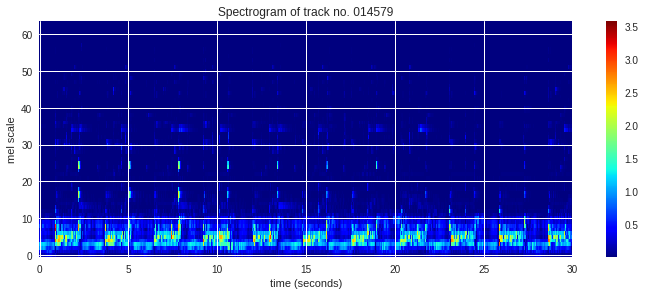

In [14]:
spectrogram_display('014579', display = "all")

### Three-second window

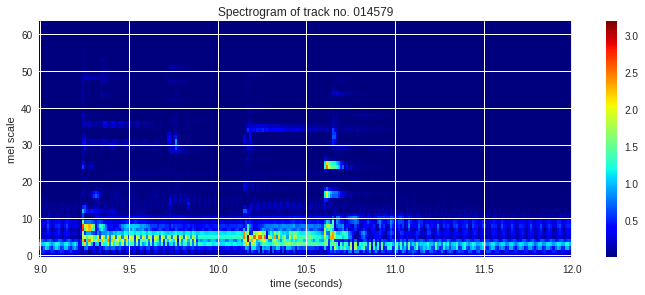

In [15]:
spectrogram_display('014579', display = 3)

## Yet more data processing

### Uniformisation of the track labels

In [0]:
# We change the file extension from .mp3 to .txt in the `tracks` sheet
# We also remove the subdirectory

tracks.track_id = tracks.track_id.apply(lambda x: str(x).rjust(6, '0'))
tracks.file_name = tracks.file_name.apply(lambda x: str(x).split('/')[1].replace('.mp3', '.txt'))
tracks.set_index('track_id', inplace = True)
tracks = tracks.reindex(file_dict.keys()).sort_index()

### Treating the data and splitting it into a training set, a validation set, and a test set

In [0]:
def full_aggregator(labels, file_dict = file_dict):
  
  return np.array([file_dict[track_id] for track_id in labels.index if file_dict[track_id].shape == (64, 2580)])



def track_aggregator(labels, file_dict = file_dict):
  
  """
  Replace labels by train_labels or test_labels in order to get the proper input,
  either for the train dataset or the test dataset
  """
  
  return np.array([np.split(file_dict[track_id], 10, 1)[i] for track_id in labels.index for i in range(0,10) if file_dict[track_id].shape == (64, 2580)])


def genre_multiplier(labels, multiplier = 10):
  
  """
  Since we split our tracks into ten 3-second long tracks, we need to multiply
  the number of labels by ten every time.
  """
  
  genre_list = []
  
  for genre in labels.genres:
    genre = [genre] * multiplier
    genre_list += genre
    
  return genre_list

In [0]:
from sklearn.model_selection import train_test_split

train_labels, test_labels = train_test_split(tracks, test_size=0.1, random_state = 2)
train_labels, validation_labels = train_test_split(train_labels, test_size = 0.1/0.9, random_state = 0)
train_labels = train_labels.sort_index()
validation_labels = validation_labels.sort_index()
test_labels = test_labels.sort_index()

In [0]:
# Our track spectrograms
#full_track = np.log(full_aggregator(tracks) + 1)
train_tracks = np.log(track_aggregator(train_labels) + 1)
validation_tracks = np.log(track_aggregator(validation_labels) + 1)
test_tracks = np.log(track_aggregator(test_labels) + 1)

#full_track = full_aggregator(tracks)
#train_tracks = track_aggregator(train_labels)
#validation_tracks = track_aggregator(validation_labels)
#test_tracks = track_aggregator(test_labels)

In [0]:
# Our genre labels (should correspond for each row)
train_genres = genre_multiplier(train_labels)
validation_genres = genre_multiplier(validation_labels)
test_genres = genre_multiplier(test_labels)

In [21]:
{label: test_genres.count(label) for label in set(test_genres)}

{'Electronic': 130,
 'Experimental': 110,
 'Folk': 120,
 'Hip-Hop': 90,
 'Instrumental': 140,
 'International': 110,
 'Pop': 180,
 'Rock': 120}

### Cropping the dataset a bit to make it more convenient to use

In [22]:
train_tracks.shape

(8000, 64, 258)

Our 3-second tracks are comprised of $258$ NumPy columns. Out of convenience, we remove the last $2$ columns in order to have $256$ columns (power of $2$).

In [0]:
#turn 258 to 256, just cut the last two columns ~
train_tracks_del = np.delete(train_tracks[:][:], range(256, train_tracks.shape[2]), axis=2)
validation_tracks_del = np.delete(validation_tracks[:][:], range(256, validation_tracks.shape[2]), axis=2)
test_tracks_del = np.delete(test_tracks[:][:], range(256, test_tracks.shape[2]), axis = 2)

In [24]:
train_tracks_del.shape

(8000, 64, 256)

In [25]:
#convert genres to array 
type(train_genres)
train_genres = np.asarray(train_genres)
train_genres[2]

'Folk'

In [0]:
np.savez_compressed('train', images=train_tracks_del, labels=train_genres)
np.savez_compressed('validation', images=validation_tracks_del, labels=validation_genres)
np.savez_compressed('test', images=test_tracks_del, labels=test_genres)

Form of the input: An image of dimension $64 \times 256$, with a single channel (equivalent to black / white)

### Preparing the specific input for the CNN

In [27]:
#vectorize the genre， convert string type labels to vectors
from keras.utils import np_utils


genres = np.unique(list(train_genres))
genres_dict = dict([[label, value] for value, label in enumerate(genres)])
G_numeric = np.asarray([genres_dict[label] for label in train_genres])
G_vectorized = np_utils.to_categorical(G_numeric)

Using TensorFlow backend.


Tensors do not accept strings as inputs, so we transform them into integers instead.

In [0]:
genre_coding = {
    'Electronic': 0,
    'Experimental': 1,
    'Folk': 2,
    'Hip-Hop': 3,
    'Instrumental': 4,
    'International': 5,
    'Pop': 6,
    'Rock': 7
}

In [0]:
train_genres_num = np.array([genre_coding[genre] for genre in train_genres])
validation_genres_num = np.array([genre_coding[genre] for genre in validation_genres])
test_genres_num = np.array([genre_coding[genre] for genre in test_genres])

In [0]:
import torchvision.transforms as transforms
train_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(np.array(l).astype(np.int64)).long()] for (e,l) in zip(train_tracks_del, train_genres_num)]
validation_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(np.array(l).astype(np.int64)).long()] for (e,l) in zip(validation_tracks_del, validation_genres_num)]
test_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(np.array(l).astype(np.int64)).long()] for (e,l) in zip(test_tracks_del, test_genres_num)]

## CNN classifier

### Implement dataloader

In [0]:
bs=100
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=bs, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
    batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=bs, shuffle=True)

In [32]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

torch.Size([1, 64, 256])
torch.Size([])


### Define a Convolutional Neural Network

In [0]:
#we use 1-channel image 

import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #64 3*3 filters with stride 1 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
        #max pooling 2*4
        self.pool = nn.MaxPool2d(2, 4)
        #64 3*5 filters with stride 1
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5), stride=1)
        #max pooling 2*4
        #dropout 0.2
        self.dropout1 = nn.Dropout2d(p=0.2, inplace=False)
        #fully connected layer 32 nerous to pervious ones 
        self.fc1 = nn.Linear(256 * 3 * 5, 32)
        #dropout 0.2
        self.dropout2 = nn.Dropout(p=0.2, inplace = False)
        #output layers 8 nerous fully connected 
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.dropout1(x)
        #print(x.shape)
        x = x.view(-1, 256 * 3 * 5)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        #print(x.shape)
        x = F.softmax(self.fc2(x), 1)
        return x


### Define a loss function
-  Cross-Entropy Loss 

In [0]:
criterion = nn.CrossEntropyLoss()

### Definition of the train function

In [0]:
def train_model(net = net, epochs = 2, bs = bs, validation = True, lr = 0.01):
  
  net.train()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  start_time = time.time()

  loss_train = np.zeros(epochs)
  acc_train = np.zeros(epochs)
  
  loss_val = np.zeros(epochs)
  acc_val = np.zeros(epochs)
  
  for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch %s – Time lapsed: %s' % (str(epoch), str(time.time() - start_time)))    
    
    running_loss = 0.0
    running_corrects = 0.0
    size = 0
    
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels = data
        
      #print(labels.shape)
      #print(i * bs)
        
      if use_gpu:
        inputs.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
        
      pred = outputs.max(1, keepdim=True)[1]
        
      size += bs
      running_loss += loss.item()
      running_corrects += pred.eq(labels.view_as(pred)).sum()
      
 
        
      #if i % 10 == 0:
      #  print(i * bs)
    
      #if i > 5:
      #  break
        
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.item() / size
    loss_train[epoch] = epoch_loss
    acc_train[epoch] = epoch_acc
    
    if validation == True:
      correct = 0
      total = 0

      net.eval()

      with torch.no_grad():
        for val_i, val_data in enumerate(validation_loader):
          val_images, val_labels = val_data
          val_outputs = net(val_images)
          _, predicted = torch.max(val_outputs.data, 1)
          total += val_labels.size(0)
          correct += (predicted == val_labels).sum().item()
          
        acc_val[epoch] = correct / total

      print('Accuracy of the network on the validation tracks: %f' % (
          correct / total))
      
      net.train()

    
    
    
    print('Train - Loss: {:.4f} Acc: {:.4f}\n'.format(epoch_loss, epoch_acc))

  print('Finished Training')
  
  return loss_train, acc_train, loss_val, acc_val

### Training the model

In [58]:
# Model definition
net = Net()

# If we have pre-trained parameters, we can load them here
parameters_filename = 'SAVED_MODEL_2.pt'

try:
  net.load_state_dict(torch.load(parameters_filename))
  print("Parameters loaded from %s" % parameters_filename)
  
except FileNotFoundError:
  print("Pre-trained parameters not found")

# Initialise parameters
# for par in net.parameters():
# par = torch.nn.init.normal_(par, mean=0, std=1)

Parameters loaded from SAVED_MODEL_2.pt


In [59]:
def trainer(learning_rates, model_save = None):
  
  """
  `learning_rates` should be a list where each element is a tuple of size two.
    - The first element should be the learning rate,
    - The second element should be the number of epochs the user wants for this
      particular learning rate.
  """
  
  loss_train, acc_train, acc_val = [], [], []
  
  for 
  
  loss_train, acc_train, loss_val, acc_val = train_model(net, 20, validation = True, lr = 0.05)
  loss_train1, acc_train1, loss_val1, acc_val1 = train_model(net, 50, validation = True, lr = 0.01)
  loss_train2, acc_train2, loss_val2, acc_val2 = train_model(net, 100, validation = True, lr = 0.001)
  
  loss_train = loss_train + loss_train1 + loss_train2
  acc_train = acc_train + acc_train1 + acc_train2
  loss_val = loss_val + loss_val1 + loss_val2
  acc_val = acc_val + acc_val1 + acc_val2
  
  if model_save is not None:
    torch.save(net.state_dict(), 'SAVED_MODEL_1.pt')
  
  return loss_train, acc_train, loss_val, acc_val
  

SyntaxError: ignored

In [53]:
loss_train, acc_train, loss_val, acc_val = trainer()

Epoch 0 – Time lapsed: 2.9087066650390625e-05
Accuracy of the network on the validation tracks: 0.494000
Train - Loss: 0.0184 Acc: 0.4319

Epoch 1 – Time lapsed: 195.91151571273804
Accuracy of the network on the validation tracks: 0.483000
Train - Loss: 0.0183 Acc: 0.4449

Epoch 2 – Time lapsed: 385.6105389595032
Accuracy of the network on the validation tracks: 0.461000
Train - Loss: 0.0182 Acc: 0.4504

Epoch 3 – Time lapsed: 575.1992061138153
Accuracy of the network on the validation tracks: 0.464000
Train - Loss: 0.0182 Acc: 0.4535

Epoch 4 – Time lapsed: 764.1491723060608
Accuracy of the network on the validation tracks: 0.469000
Train - Loss: 0.0180 Acc: 0.4639

Epoch 5 – Time lapsed: 952.7196931838989
Accuracy of the network on the validation tracks: 0.475000
Train - Loss: 0.0179 Acc: 0.4814

Epoch 6 – Time lapsed: 1142.895940542221
Accuracy of the network on the validation tracks: 0.421000
Train - Loss: 0.0179 Acc: 0.4819

Epoch 7 – Time lapsed: 1332.749092578888
Accuracy of the

KeyboardInterrupt: ignored

In [0]:
def test_model(data_loader = test_loader, net = net):
  
  correct = 0
  total = 0

  net.eval()

  with torch.no_grad():
    for i, data in enumerate(data_loader):
      images, labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test tracks: %f %%' % (correct / total))
  return correct/total

In [61]:
test_model(data_loader = test_loader)

Accuracy of the network on the test tracks: 0.457000 %


0.457

In [63]:
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        genres[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Electronic : 25 %
Accuracy of Experimental : 50 %
Accuracy of  Folk : 75 %
Accuracy of Hip-Hop : 80 %
Accuracy of Instrumental : 40 %
Accuracy of International : 50 %
Accuracy of   Pop :  0 %
Accuracy of  Rock : 33 %
